# Final Project

### By: Garrick Hague

#### Only fires that are >200 Hectares are in this dataset
#### https://cwfis.cfs.nrcan.gc.ca/datamart/download/nfdbpoly



In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Disable the warning
warnings.filterwarnings('ignore')

In [2]:
# Loading in fire data
gdf = gpd.read_file('/Users/garrickhague/Desktop/Classes/ATMS_523/fire_data/NFDB_poly_large_fires/NFDB_poly_20210707_large_fires.shp')

In [3]:
# Loading in the climate indices
enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/pdo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=14, engine='python')
nao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/nao.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')
ao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/ao.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')

In [4]:
# Dropping extra rows not needed
enso.drop(75, inplace=True)
nao.drop([75, 76], inplace=True)

# Creating empty dataframes
enso_new=pd.DataFrame()    
pdo_new=pd.DataFrame()
nao_new=pd.DataFrame()
ao_new=pd.DataFrame()

# Creating range of dates from 1948-2022
enso_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")
pdo_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")
nao_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")
ao_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")


# Extracting and assigning values to new DataFrames
len(enso.loc[:,1:].stack().values)
len(pdo.loc[:,1:].stack().values)
len(nao.loc[:,1:].stack().values)
len(pdo.loc[:,1:].stack().values)

# Extracting and assigning values to new DataFrames
enso_new['ENSO']=enso.loc[:,1:].stack().values
pdo_new['PDO']=pdo.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack().values
ao_new['AO']=ao.loc[:,1:].stack().values

# Converting 'Date' column to period format
enso_new['Date'] = enso_new['Date'].dt.to_period('M')
pdo_new['Date'] = pdo_new['Date'].dt.to_period('M')
nao_new['Date'] = nao_new['Date'].dt.to_period('M')
ao_new['Date'] = ao_new['Date'].dt.to_period('M')

# Merge teleconnections
merged_df = pd.merge(enso_new, pdo_new, on='Date')
merged_df = pd.merge(merged_df, nao_new, on='Date')
merged_df = pd.merge(merged_df, ao_new, on='Date')

# Data Exploration

In [6]:
# Printing 5 rows in dataframe
gdf.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,YEAR,MONTH,DAY,REP_DATE,DATE_TYPE,OUT_DATE,DECADE,SIZE_HA,CALC_HA,CAUSE,MAP_SOURCE,SOURCE_KEY,MAP_METHOD,WATER_REM,UNBURN_REM,MORE_INFO,POLY_DATE,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,AG_SRCFILE,ACQ_DATE,SRC_AGY2,geometry
0,BC,2004-C10175,None,2004,6,23,2004-06-23,Report date,None,2000-2009,1370.5,1370.507344,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C10175,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1886926.467 898021.006 0.000, -18..."
1,BC,2004-C10176,None,2004,6,23,2004-06-23,Report date,None,2000-2009,520.7,520.796287,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C10176,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1880308.251 892344.865 0.000, -18..."
2,BC,2004-C50114,None,2004,6,20,2004-06-20,Report date,None,2000-2009,268.2,268.290572,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C50114,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1965048.293 820512.199 0.000, -19..."
3,BC,2004-C50125,None,2004,6,21,2004-06-21,Report date,None,2000-2009,20506.4,20506.415129,L,Satellite imagery,LANDSAT5,Modified from Protection,None,None,None,2007-05-17,BC-2004-C50125,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1995073.527 854615.146 0.000, -19..."
4,BC,2004-C50149,None,2004,6,22,2004-06-22,Report date,None,2000-2009,2408.5,2408.587142,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C50149,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1988211.829 940418.674 0.000, -19..."


In [7]:
# Looking at how many rows are in dataframe
gdf.index.size

21838

In [8]:
# Looking at all the columns
gdf.columns

Index(['SRC_AGENCY', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'DATE_TYPE', 'OUT_DATE', 'DECADE', 'SIZE_HA', 'CALC_HA', 'CAUSE',
       'MAP_SOURCE', 'SOURCE_KEY', 'MAP_METHOD', 'WATER_REM', 'UNBURN_REM',
       'MORE_INFO', 'POLY_DATE', 'CFS_REF_ID', 'CFS_NOTE1', 'CFS_NOTE2',
       'AG_SRCFILE', 'ACQ_DATE', 'SRC_AGY2', 'geometry'],
      dtype='object')

In [9]:
# Need the Years to match with the climate indices but want to see how much data is less than the years
print("       Less than 1950:         ", (gdf['YEAR'] < 1950).sum()) 
print("Greater than or equal to 1950: ", (gdf['YEAR'] >= 1950).sum())

       Less than 1950:          4451
Greater than or equal to 1950:  17387


In [36]:
# Looking at the total amount burned per agency
gdf.groupby('SRC_AGENCY')['CALC_HA'].sum().sort_values(ascending=False)

SRC_AGENCY
NT       2.555706e+07
SK       2.408626e+07
MB       2.057695e+07
AB       1.478405e+07
BC       1.445835e+07
QC       1.413042e+07
YT       1.024603e+07
ON       9.196873e+06
PC-WB    3.088456e+06
NL       1.084143e+06
PC-NA    1.934938e+05
NB       6.796683e+04
PC-RM    4.732262e+04
PC-PU    4.143327e+04
PC-BA    3.209058e+04
PC-JA    2.954138e+04
PC-PA    2.783730e+04
PC-KO    2.341774e+04
NS       1.899467e+04
PC-NI    1.380462e+04
PC-EI    1.128118e+04
PC-WL    4.653877e+03
PC-WP    4.134184e+03
PC-GR    4.025784e+03
PC-GL    2.678430e+03
PC-YO    1.515768e+03
PC-LM    1.299397e+03
PC-VU    1.225567e+03
PC-RE    2.439879e+02
Name: CALC_HA, dtype: float64

In [10]:
# Looking at climate indices
merged_df

,Date,ENSO,PDO,NAO,AO
0,1948-01,0.26,-0.11,-99.90,-0.060
1,1948-02,0.43,-0.74,-99.90,0.627
2,1948-03,0.72,-0.03,-99.90,-0.008
3,1948-04,0.21,-1.33,-99.90,0.555
4,1948-05,0.24,-0.23,-99.90,0.072
...,...,...,...,...,...
895,2022-08,-1.45,-9.90,1.76,-999.000
896,2022-09,-1.79,-9.90,-1.42,-999.000
897,2022-10,-1.78,-9.90,-0.27,-999.000
898,2022-11,-0.63,-9.90,0.59,-999.000


In [11]:
merged_df.describe()

,ENSO,PDO,NAO,AO
count,900.000000,900.000000,900.000000,900.000000
mean,0.013567,-0.176233,-2.730056,-8.968619
std,0.985378,1.366343,16.128617,93.816215
min,-3.050000,-9.900000,-99.900000,-999.000000
25%,-0.620000,-0.930000,-0.930000,-0.652750
50%,0.000000,-0.105000,-0.060000,-0.047000
75%,0.650000,0.652500,0.652500,0.483000
max,3.080000,3.510000,3.060000,3.495000


# Data Processing


In [40]:
# Reducing years to match climate indices
reduced_years_df = gdf[gdf['YEAR'] >= 1950]

# Filtering data for columns used in analysis
filter_df = reduced_years_df[['SRC_AGENCY', 'REP_DATE', 'CALC_HA']]

# Convert REP_DATE to datetime object
filter_df['REP_DATE'] = pd.to_datetime(filter_df['REP_DATE']).dt.to_period('M')

# Renaming column to have matching names for future merge
filter_df = filter_df.rename(columns={'REP_DATE' : 'Date'})

# Dropping Nan values for Date column
filter_df = filter_df.dropna(subset=['Date'])

In [41]:
agency_name = ['NT', 'SK', 'MB', 'AB', 'BC']
agency = ['NT', 'SK', 'MB', 'AB', 'BC']

# Dictionary to store filtered DataFrames
filtered_data = {}  

for name, code in zip(agency_name, agency):
    filtered_data[name] = filter_df[filter_df['SRC_AGENCY'] == code]

In [49]:
# Groupby date and adding different events together for each agency
nt_data = filtered_data['NT'].groupby('Date')['CALC_HA'].sum()
sk_data = filtered_data['SK'].groupby('Date')['CALC_HA'].sum()
mb_data = filtered_data['MB'].groupby('Date')['CALC_HA'].sum()
ab_data = filtered_data['AB'].groupby('Date')['CALC_HA'].sum()
bc_data = filtered_data['BC'].groupby('Date')['CALC_HA'].sum()

### Processing Climate indices and merging the 2 dataframes together

In [13]:
# Merging tornado's and teleconnections
full_merged_df = pd.merge(filter_df, merged_df, on='Date', how='left')

# Sorting values
full_merged_df = full_merged_df.sort_values(by='Date')

# Reset Index
full_merged_df.reset_index(inplace=True)

# Drop index
full_merged_df.drop(columns='index', inplace=True)

# Add Year and Month columns for regressor
full_merged_df['Year'] = full_merged_df['Date'].dt.year
full_merged_df['Month'] = full_merged_df['Date'].dt.month

,SRC_AGENCY,Date,CALC_HA,CAUSE,ENSO,PDO,NAO,AO,Year,Month
0,PC-WB,1950-05,7046.073140,H,-1.22,-2.23,-0.50,-0.773,1950,5
1,BC,1950-05,550.472405,H,-1.22,-2.23,-0.50,-0.773,1950,5
2,BC,1950-05,1498.134134,H,-1.22,-2.23,-0.50,-0.773,1950,5
3,BC,1950-06,316.525373,H,-1.69,-1.77,0.25,-0.441,1950,6
4,PC-WB,1950-06,315.548160,L,-1.69,-1.77,0.25,-0.441,1950,6
...,...,...,...,...,...,...,...,...,...,...
14304,BC,2020-08,1303.102871,L,-1.19,-0.28,0.03,-0.170,2020,8
14305,BC,2020-08,7645.487876,L,-1.19,-0.28,0.03,-0.170,2020,8
14306,BC,2020-08,2141.455496,U,-1.19,-0.28,0.03,-0.170,2020,8
14307,ON,2020-08,391.589907,L,-1.19,-0.28,0.03,-0.170,2020,8


In [15]:
# Define the list of agencies not needed
agencies_to_include = ['PC-WB', 'PC-PU', 'PC-NA', 'PC-NI', 'PC-PA', 'PC-EI', 'PC-WL', 'PC-BA', 'PC-RM', 'PC-JA', 'PC-KO', 'PC-RE', 'PC-GL', 'PC-YO', 'PC-VU', 'PC-GR']

# Filter the DataFrame to include only rows where the 'SRC_AGENCY' column matches the values in the list
filtered_df = full_merged_df[full_merged_df['SRC_AGENCY'].isin(agencies_to_include)]

# Sum up the 'CALC_HA' column in the filtered DataFrame
total_area_burned = filtered_df['CALC_HA'].sum()

# Calculate the total area burned for the original DataFrame
total_area_burned_original = full_merged_df['CALC_HA'].sum()

# Calculate the percentage of total_area_burned compared to the total area burned in the original DataFrame
percentage_of_total = (total_area_burned / total_area_burned_original) * 100

print("Percentage of total area burned for specified agencies compared to total area burned in the original DataFrame:", percentage_of_total, "%")

Percentage of total area burned for specified agencies compared to total area burned in the original DataFrame: 2.615120309004307 %


In [16]:
# Drop the rows where the 'SRC_AGENCY' column matches the values in the list
full_merged_df = full_merged_df[~full_merged_df['SRC_AGENCY'].isin(agencies_to_include)]

full_merged_df['SRC_AGENCY'].unique()

array(['BC', 'AB', 'YT', 'SK', 'ON', 'NT', 'QC', 'MB', 'NB', 'NS', 'NL'],
      dtype=object)

In [17]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Encode the 'SRC_AGENCY' column
full_merged_df['SRC_AGENCY_encoded'] = label_encoder.fit_transform(full_merged_df['SRC_AGENCY'])

# Encode the 'CAUSE' column
full_merged_df['CAUSE_encoded'] = label_encoder.fit_transform(full_merged_df['CAUSE'])

In [18]:
full_merged_df

,SRC_AGENCY,Date,CALC_HA,CAUSE,ENSO,PDO,NAO,AO,Year,Month,SRC_AGENCY_encoded,CAUSE_encoded
1,BC,1950-05,550.472405,H,-1.22,-2.23,-0.50,-0.773,1950,5,1,0
2,BC,1950-05,1498.134134,H,-1.22,-2.23,-0.50,-0.773,1950,5,1,0
3,BC,1950-06,316.525373,H,-1.69,-1.77,0.25,-0.441,1950,6,1,0
5,BC,1950-06,320.413241,H,-1.69,-1.77,0.25,-0.441,1950,6,1,0
6,BC,1950-06,4984.951853,L,-1.69,-1.77,0.25,-0.441,1950,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14304,BC,2020-08,1303.102871,L,-1.19,-0.28,0.03,-0.170,2020,8,1,2
14305,BC,2020-08,7645.487876,L,-1.19,-0.28,0.03,-0.170,2020,8,1,2
14306,BC,2020-08,2141.455496,U,-1.19,-0.28,0.03,-0.170,2020,8,1,3
14307,ON,2020-08,391.589907,L,-1.19,-0.28,0.03,-0.170,2020,8,7,2


In [19]:
full_merged_df.describe()

,CALC_HA,ENSO,PDO,NAO,AO,Year,Month,SRC_AGENCY_encoded,CAUSE_encoded
count,13937.000000,13937.000000,13937.000000,13937.000000,13937.000000,13937.000000,13937.000000,13937.000000,13937.000000
mean,7280.693907,0.120153,0.243555,0.102676,-0.078406,1993.302074,6.584272,5.210232,1.651001
std,25914.824782,0.881907,1.038179,1.112773,0.578752,17.168511,1.101913,3.365422,0.788955
min,2.101583,-2.560000,-2.930000,-3.140000,-1.917000,1950.000000,1.000000,0.000000,0.000000
25%,473.327715,-0.540000,-0.470000,-0.560000,-0.489000,1981.000000,6.000000,1.000000,2.000000
50%,1279.455144,0.120000,0.210000,0.240000,-0.102000,1995.000000,7.000000,6.000000,2.000000
75%,4678.091814,0.710000,0.890000,1.000000,0.345000,2008.000000,7.000000,8.000000,2.000000
max,828531.701207,2.970000,3.510000,3.060000,3.279000,2020.000000,12.000000,10.000000,4.000000


# Visualize the data

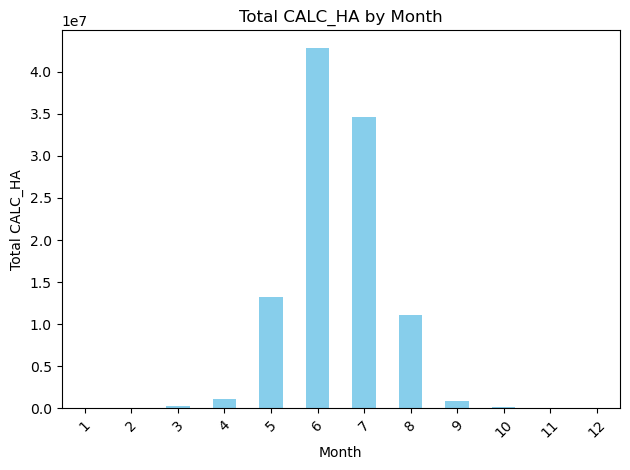

In [ ]:
# Make a deep copy of the DataFrame
df_copy = full_merged_df.copy()

# Grouping by month
grouped_data = df_copy.groupby('Month')['CALC_HA'].sum()

# Plotting
grouped_data.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total CALC_HA')
plt.title('Total CALC_HA by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

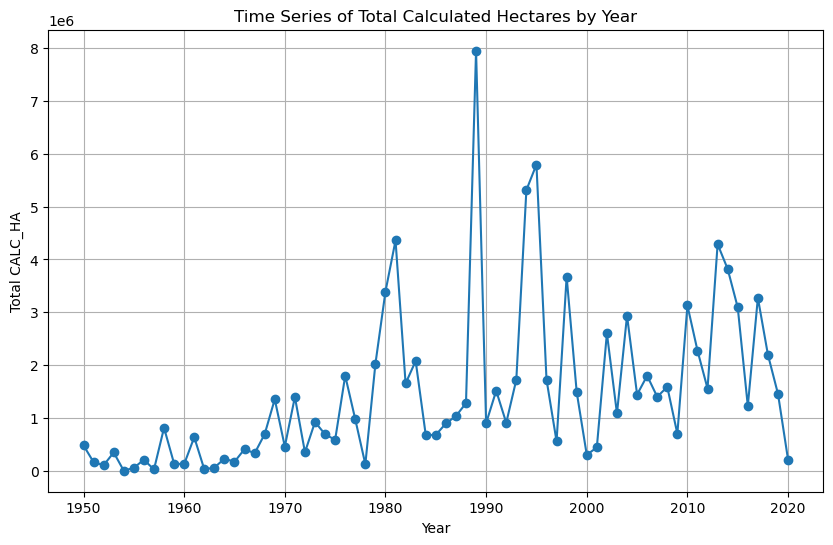

In [ ]:
# Group the data by 'Year' and calculate the sum of 'CALC_HA' for each year
yearly_sum_data = df_copy.groupby('Year')['CALC_HA'].sum()

# Plotting the time series
plt.figure(figsize=(10, 6))
yearly_sum_data.plot(marker='o', linestyle='-')
plt.title('Time Series of Total Calculated Hectares by Year')
plt.xlabel('Year')
plt.ylabel('Total CALC_HA')
plt.grid(True)
plt.show()

In [20]:
full_merged_df

,SRC_AGENCY,Date,CALC_HA,CAUSE,ENSO,PDO,NAO,AO,Year,Month,SRC_AGENCY_encoded,CAUSE_encoded
1,BC,1950-05,550.472405,H,-1.22,-2.23,-0.50,-0.773,1950,5,1,0
2,BC,1950-05,1498.134134,H,-1.22,-2.23,-0.50,-0.773,1950,5,1,0
3,BC,1950-06,316.525373,H,-1.69,-1.77,0.25,-0.441,1950,6,1,0
5,BC,1950-06,320.413241,H,-1.69,-1.77,0.25,-0.441,1950,6,1,0
6,BC,1950-06,4984.951853,L,-1.69,-1.77,0.25,-0.441,1950,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14304,BC,2020-08,1303.102871,L,-1.19,-0.28,0.03,-0.170,2020,8,1,2
14305,BC,2020-08,7645.487876,L,-1.19,-0.28,0.03,-0.170,2020,8,1,2
14306,BC,2020-08,2141.455496,U,-1.19,-0.28,0.03,-0.170,2020,8,1,3
14307,ON,2020-08,391.589907,L,-1.19,-0.28,0.03,-0.170,2020,8,7,2


# Training Different models

# First lets look at Linear Regression

In [27]:
X = full_merged_df[['CAUSE_encoded', 'SRC_AGENCY_encoded', 'ENSO', 'PDO', 'NAO', 'AO', 'Year', 'Month']]
y = full_merged_df['CALC_HA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Root Mean Squared Error (RMSE): 18456.34287079292
R-squared (R2): 0.002855207102568813


# Now lets look at Random Forest Regressor to see if we can import model performance

In [28]:
# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Compute evaluation metrics for Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics:")
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared (R2):", r2_rf)

Random Forest Regression Metrics:
Root Mean Squared Error (RMSE): 20433.724094631747
R-squared (R2): -0.22225543325445685


# Lets Do a Grid Search with 5 cross validations to see what parameters create the pest performance

In [ ]:
# # Define parameter grid
# param_grid = {
#     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
#     'bootstrap': [True, False],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10]
# }

# # Create Random Forest
# rf = RandomForestRegressor()

# # Create GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# # Train the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# print("Best Parameters:", best_params)

In [29]:
# Define parameter grid
param_grid = {
    'n_estimators': [600],
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4],
    'min_samples_split': [2]
}

# Create Random Forest
rf = RandomForestRegressor()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 600}


In [30]:
# Create a Random Forest regressor with the best parameters
best_rf_model = RandomForestRegressor(**best_params)

# Train the model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the model using the evaluation metrics
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("Random Forest Regression Metrics with Best Parameters:")
print("Root Mean Squared Error (RMSE):", rmse_best)
print("R-squared (R2):", r2_best)

Random Forest Regression Metrics with Best Parameters:
Root Mean Squared Error (RMSE): 18432.518364251708
R-squared (R2): 0.005427888992103225


# Lets seperate the data into different agencys and groupby month

In [ ]:
fil